<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [80]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem
import statsmodels.stats.api as sms


import pylab as plt

In [2]:
# datos

cat = pd.read_csv('data/cookie_cats.csv')
cat.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [19]:
cat.shape

(90189, 5)

## Testeo frecuentista

### Retención día 1

In [22]:
# transformacion

cross = pd.crosstab(cat.version == 'gate_30', cat.retention_1 == 'gate_40')
cross

retention_1,False
version,
False,45489
True,44700


In [15]:
cat['userid'].value_counts(ascending=False)

# otra forma de comprobar que no hay usuarios repetitos en las versiones

userid
116        1
6632278    1
6658202    1
6658194    1
6658134    1
          ..
3347358    1
3347337    1
3346992    1
3346979    1
9999861    1
Name: count, Length: 90189, dtype: int64

In [27]:
cross2 = pd.crosstab(cat['version'], cat['retention_1'])
cross2

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [31]:
cross2[True][0]

20034

In [49]:
pro30 = (cross2[True][0]/cross[False][1]).round(2)
pro30

0.45

In [50]:
pro40 = (cross2[True][1]/cross[False][0]).round(2)
pro40

0.44

In [51]:
efecto=sms.proportion_effectsize(pro30, pro40)

efecto

0.02012246123322825

In [57]:
n_requerido = sms.NormalIndPower().solve_power(efecto,
                                               power=0.8,
                                               alpha=0.05)

n_requerido = int(n_requerido)


In [61]:
# muestreo
cua = cat[cat['version'] == 'gate_40'].sample(n = n_requerido, random_state=22)
tre = cat[cat['version'] == 'gate_30'].sample(n = n_requerido, random_state=22)

ab_test=pd.concat([tre, cua], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,7540471,gate_30,45,True,False
1,3589138,gate_30,21,True,False
2,3177668,gate_30,14,True,False
3,2133884,gate_30,26,False,False
4,492763,gate_30,39,True,True


In [73]:
len(ab_test)

77536

In [63]:
observaciones = [38768, 38768]
ab_test.version.value_counts()

version
gate_30    38768
gate_40    38768
Name: count, dtype: int64

In [65]:
# testeo para retention_1
tre_res = ab_test[ab_test.version=='gate_30']['retention_1']
cua_res = ab_test[ab_test.version=='gate_40']['retention_1']


In [76]:
tre_res.value_counts()

retention_1
False    21394
True     17374
Name: count, dtype: int64

In [75]:
sum(tre_res)

17374

In [77]:
conversiones=[tre_res.sum(), cua_res.sum()]
z_score, p_value = proportions_ztest(conversiones, nobs=observaciones)

(tre_a, cua_a), (tre_b, cua_b) = proportion_confint(conversiones, 
                                                                nobs=observaciones,
                                                                alpha=0.05)

In [99]:
print(f'z-score: {z_score:.2f}')

print(f'p-valor: {p_value:.3f}')

print(f'intervalo conf 95% para grupo 30: [{tre_a:.3f}, {tre_b:.3f}]')

print(f'intervalo conf 95% para grupo 40: [{cua_a:.3f}, {cua_b:.3f}]')

z-score: 1.21
p-valor: 0.225
intervalo conf 95% para grupo 30: [0.443, 0.453]
intervalo conf 95% para grupo 40: [0.439, 0.449]


In [ ]:
x=[i*.1 for i in range(-5, 8)]  

control=[norm.pdf(x, tasas_conversion.iloc[0][0], tasas_conversion.iloc[0][1]) for x in x] 

tratamiento=[norm.pdf(x, tasas_conversion.iloc[1][0], tasas_conversion.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.legend(['control', 'tratamiento'])

In [89]:
import scipy.stats as stats

In [92]:
#%pip install Jinja2

In [93]:
tasas_conversion = ab_test.groupby('version')['retention_1']

std = lambda x: np.std(x, ddof=0)              # std
error_std= lambda x: stats.sem(x, ddof=0)      # sem = std/sqrt(n)

tasas_conversion = tasas_conversion.agg([np.mean, std, error_std])

tasas_conversion.columns = ['conversion_rate', 'std', 'sem']

tasas_conversion.style.format('{:.3f}')


,conversion_rate,std,sem
version,,,
gate_30,0.448,0.497,0.003
gate_40,0.444,0.497,0.003


In [95]:
tasas_conversion.iloc[0][0]

0.44815311597193563

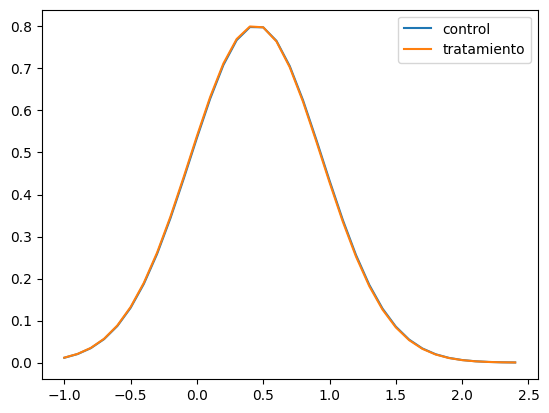

In [98]:
x=[i*.1 for i in range(-10, 25)]  

control=[norm.pdf(x, 
                  ) for x in x] 

tratamiento=[norm.pdf(x, tasas_conversion.iloc[1][0], tasas_conversion.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.legend(['control', 'tratamiento']);

## Conclusiones retención día 1

Con este resultado podemos aceptar la hipótesis, es decir que no hay diferencia significativa entre los grupos. Asimismo, vemos que el intervalo de confianza para el grupo 40 no se ajusta a nuestro pocentaje.

## Testeo Bayes

### Retención día 7

In [111]:
from bayes import *

In [112]:
def bayes(priori, verosimilitud):
    
    marginal = sum(np.multiply(priori, verosimilitud)) # cte normalizacion
    
    posteriori = np.divide(np.multiply(priori, verosimilitud), marginal)
    
    return posteriori

In [113]:
cross = pd.crosstab(cat.version == 'gate_30', cat.retention_7 == 'gate_40')
cross

retention_7,False
version,
False,45489
True,44700


In [114]:
cross2 = pd.crosstab(cat['version'], cat['retention_7'])
cross2

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [115]:
vis_30, com_30 = 36198 + 8502, 8502
vis_40, com_40 = 37210 + 8279, 8279

cr_30 = com_30/vis_30
cr_40 = com_40/vis_40

print('Tasas', cr_30, cr_40)

Tasas 0.19020134228187918 0.18200004396667327


In [117]:
# las apriori

a_30, b_30 = com_30 + 1, vis_30 - com_30 + 1
a_40, b_40 = com_40 + 1, vis_40 - com_40 + 1

# las betas

beta_30 = beta(a_30, b_30)
beta_40 = beta(a_40, b_40)

In [118]:
salto = ((beta_40.mean() - beta_30.mean()) / beta_30.mean())
salto

-0.04311526114658881

In [121]:
prob = calc_prob(beta_30, beta_40)
prob

0.9992226613235504

In [125]:
print (
'''El test disminuye la tasa de conversion en un {:2.2f}%,
con una probabilidad del {:2.2f}%'''
    .format(salto * 100, prob * 100)
)

El test disminuye la tasa de conversion en un -4.31%,
con una probabilidad del 99.92%


0.19020134228187918 0.18200004396667327


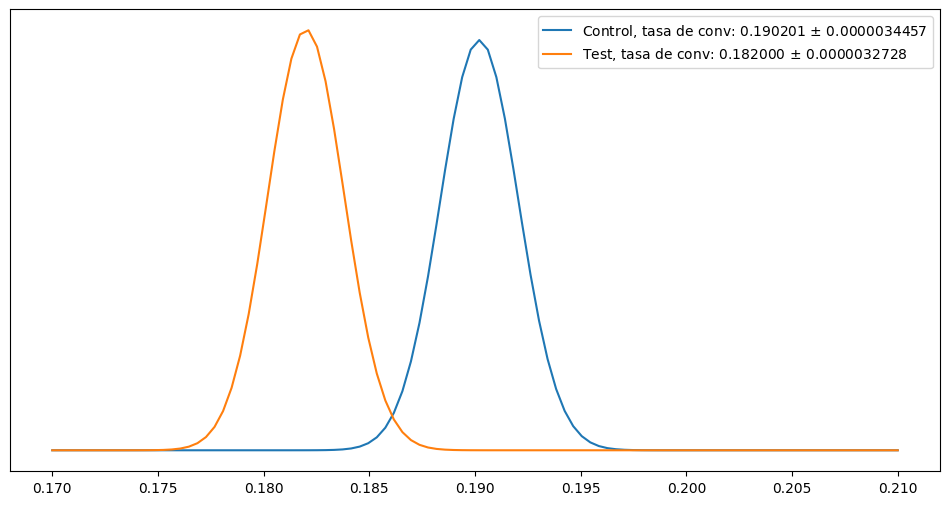

In [124]:
print(cr_30, cr_40)
plt.figure(figsize = (12,6))
plot([beta_30, beta_40], ['Control', 'Test'], lsup = 0.17, linf = 0.21)

## Conclusiones

Hemos comprobado con un 99.92$ de probabilidad que el test disminuye la tasa de conversión. Esto quiere decir que la versión 30 es mejor que la 40 y hay que comentarle a los de UX que lo chequeen o al jefe que no use la 40.